In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
path = str('/domino/datasets/local/{}/WineQualityData.csv'.format(os.environ.get('DOMINO_PROJECT_NAME')))
df = pd.read_csv(path)
df.head()

,id,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,5.58,0
1,1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,5.04,0
2,2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,5.34,0
3,3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,4.92,0
4,4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,5.16,0


<AxesSubplot:xlabel='quality', ylabel='Count'>

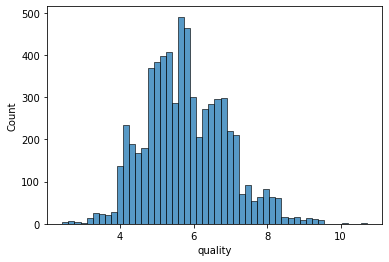

In [3]:
sns.histplot(df.quality)

In [4]:
for col in df.columns:
    df.rename({col: col.replace(' ', '_')}, axis =1, inplace = True)

In [5]:
df['is_red'] = df.type.apply(lambda x : int(x=='red'))

In [6]:
df.type.value_counts()

white    4898
red      1599
Name: type, dtype: int64

In [7]:
df.is_red.value_counts()

0    4898
1    1599
Name: is_red, dtype: int64

In [8]:
na_values = df.isna().sum()
na_values = na_values[na_values>0]
na_values

fixed_acidity       10
volatile_acidity     8
citric_acid          3
residual_sugar       2
chlorides            2
pH                   9
sulphates            4
dtype: int64

In [9]:
corr_values = df.corr().sort_values(by = 'quality')['quality'].drop('quality',axis=0)

In [10]:
important_feats=corr_values[abs(corr_values)>0.08]
important_feats

density            -0.234881
volatile_acidity   -0.199486
chlorides          -0.148369
is_red             -0.080618
alcohol             0.341581
Name: quality, dtype: float64

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

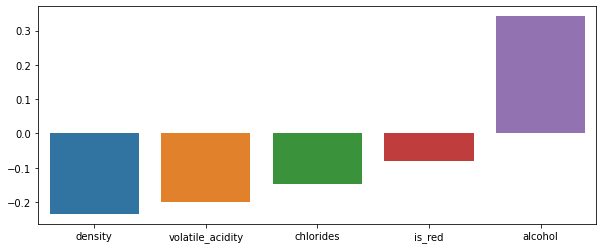

In [11]:
plt.figure(figsize=(10,4))
sns.barplot(important_feats.keys(), important_feats.values)

<AxesSubplot:xlabel='alcohol', ylabel='quality'>

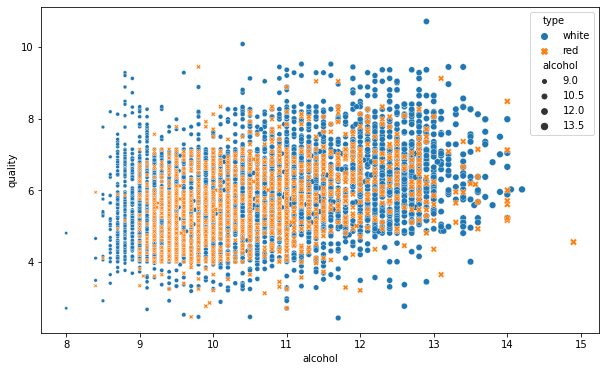

In [12]:
fig, ax1 = plt.subplots(figsize=(10,6))
sns.scatterplot(x=df.alcohol, y = df.quality, hue =df.type, style = df.type, size= df.alcohol, sizes=(10,50))

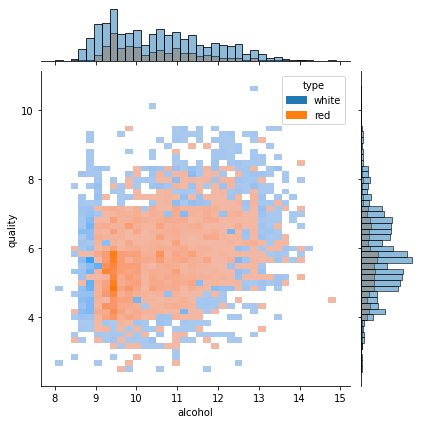

In [13]:
sns.jointplot(kind = 'hist', x=df.alcohol, y = df.quality, hue = df.type)

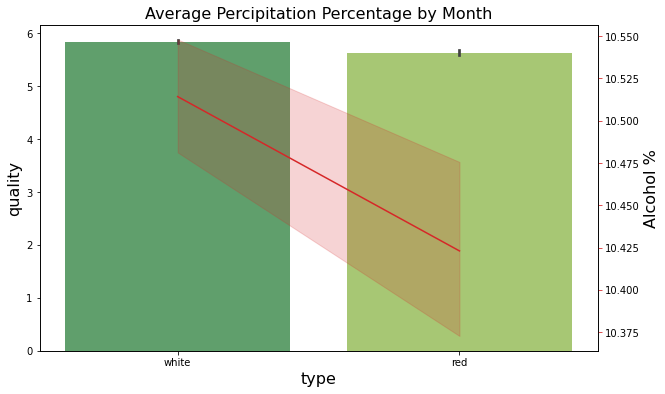

In [14]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
#bar plot creation
ax1.set_title('Average Percipitation Percentage by Month', fontsize=16)
ax1.set_xlabel('Month', fontsize=16)
ax1.set_ylabel('Avg Temp', fontsize=16)
ax1 = sns.barplot(x=df.type, y=df.quality, palette='summer')
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Alcohol %', fontsize=16)
ax2 = sns.lineplot(x=df.type, y=df.alcohol, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
important_feats.keys()

Index(['density', 'volatile_acidity', 'chlorides', 'is_red', 'alcohol'], dtype='object')

In [45]:
from sklearn.model_selection import train_test_split
df = df.dropna(how='any',axis=0)
X = df[important_feats.keys()]
# X = df.drop(['type','quality'], axis=1)
y = df['quality'].astype('float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

In [46]:
X.dtypes

density             float64
volatile_acidity    float64
chlorides           float64
is_red                int64
alcohol             float64
dtype: object

In [47]:
y.dtypes

dtype('float64')

In [48]:
X.isna().sum()

density             0
volatile_acidity    0
chlorides           0
is_red              0
alcohol             0
dtype: int64

In [49]:
import autosklearn

In [50]:
from autosklearn import automl

In [51]:
%%time
aml = automl.AutoMLRegressor(time_left_for_this_task =30, per_run_time_limit=30)
# aml.fit(X_train,y_train)

CPU times: user 44 µs, sys: 5 µs, total: 49 µs
Wall time: 52.2 µs


In [52]:
gbr = GradientBoostingRegressor(loss='ls',learning_rate = 0.15, n_estimators=75, criterion = 'mse')

gbr.fit(X_train,y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.15, n_estimators=75)

In [53]:
from sklearn.metrics import mean_squared_error, r2_score
preds = gbr.predict(X_test)
print("R2 Score: ", round(r2_score(y_test, preds),3))
print("MSE: ", round(mean_squared_error(y_test, preds),3))

R2 Score:  0.226
MSE:  0.925


In [27]:
round(r2_score(y_test, preds),3)

0.221

In [28]:
from sklearn.ensemble import AdaBoostRegressor

adb = AdaBoostRegressor()
adb.fit(X_train,y_train)

AdaBoostRegressor()

In [29]:
preds = adb.predict(X_test)
print("R2 Score: ", round(r2_score(y_test, preds),3))
print("MSE: ", round(mean_squared_error(y_test, preds),3))

R2 Score:  0.183
MSE:  0.983


In [30]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [31]:
preds = rfr.predict(X_test)
print("R2 Score: ", round(r2_score(y_test, preds),3))
print("MSE: ", round(mean_squared_error(y_test, preds),3))

R2 Score:  0.172
MSE:  0.997


In [28]:
import json
with open('dominostats.json', 'w') as f:
    f.write(json.dumps({"R2": round(r2_score(y_test, preds),3),
                       "MSE": round(mean_squared_error(y_test,preds),3)}))

In [29]:
import json
with open('dominostats.json', 'w') as f:
    f.write(json.dumps({"R^2": 0.99, "p-value": 0.05, "sse": 10.49}))

In [32]:
results = pd.DataFrame({'Actuals':y_test, 'Predictions':preds})

In [33]:
results

,Actuals,Predictions
1143,5.65,6.012347
2708,6.84,5.776850
4943,3.64,5.917133
4194,6.30,6.007500
5956,6.51,6.243300
...,...,...
1133,4.95,5.214060
105,6.72,5.829045
4423,5.46,5.596900
3637,7.21,6.590525


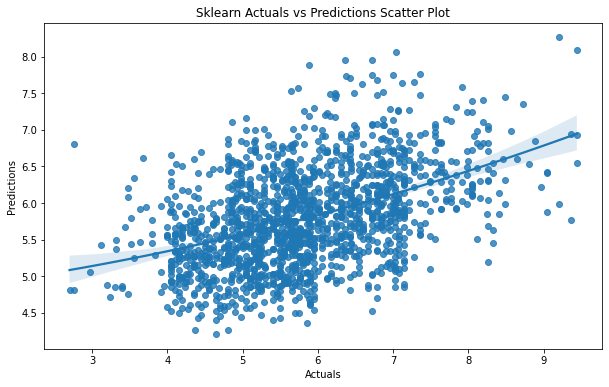

In [34]:
fig1, ax1 = plt.subplots(figsize=(10,6))
plt.title('Sklearn Actuals vs Predictions Scatter Plot')
sns.regplot( 
    data=results,
    x = 'Actuals',
    y = 'Predictions',
    order = 2)
plt.savefig('/mnt/visualizations/sklearn_actual_v_pred_scatter.png')

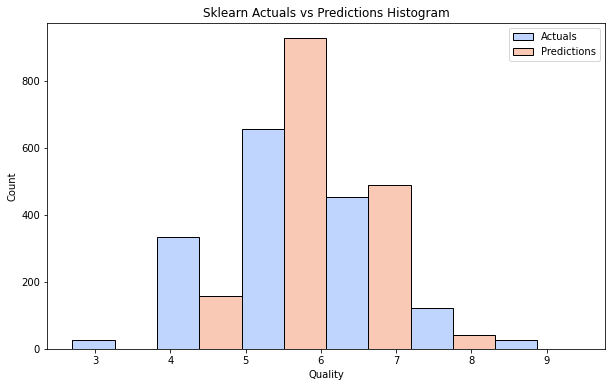

In [35]:
fig2, ax2 = plt.subplots(figsize=(10,6))
plt.title('Sklearn Actuals vs Predictions Histogram')
plt.xlabel('Quality')
sns.histplot(results, bins=6, multiple = 'dodge', palette = 'coolwarm')
plt.savefig('/mnt/visualizations/sklearn_actual_v_pred_hist.png')

In [36]:
import pickle 

# save best model
file = '/mnt/models/sklearn_gbm.pkl'
pickle.dump(gbr, open(file, 'wb'))

In [38]:
X.head()

,density,volatile_acidity,chlorides,is_red,alcohol
0,1.0010,0.27,0.045,0,8.8
1,0.9940,0.30,0.049,0,9.5
2,0.9951,0.28,0.050,0,10.1
3,0.9956,0.23,0.058,0,9.9
4,0.9956,0.23,0.058,0,9.9
